# ДЗ №5
### *виконала студентка групи ФБ-33 Журавльова Марія* ###

Нагадаю, що мій набір даних - TMDB 10000 Movies Dataset (https://www.kaggle.com/datasets/i0xc0d3x00000/tmdb-10000-movies-dataset)

**Опис колонок:**

- title - назва фільму;
- overview - опис сюжету фільму;
- release_date - оригінальна дата випуску;
- vote_average - середній рейтинг фільму;
- vote_count - кількість отриманих голосів;
- original_language - мова зйомки;
- popularity - індекс популярності.

**Промоделювати множинну лінійну регресію на вашому датасеті:**
- намалювати лінію регресії;
- написати рівняння множинної регресії;

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Завантаження даних
df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\university\МТАД\movie_tmdb_clean.csv")

# Логарифмування для нормалізації розподілу та зглажування нелінійності
df['log_vc'] = np.log1p(df['vote_count'])
df['log_p'] = np.log1p(df['popularity'])

# Централізація року для зменшення потенційної кореляції між роком та константою
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['year_centered'] = df['release_year'] - df['release_year'].mean()

# врахування впливу основної мови
top_lang = df['original_language'].value_counts().nlargest(1).index[0]
df_final = pd.get_dummies(df, columns=['original_language'], drop_first=False, prefix='lang')
lang_col = f'lang_{top_lang}' if f'lang_{top_lang}' in df_final.columns else None

Y = df['vote_average']

X_features = ['log_vc', 'log_p', 'year_centered'] 
if lang_col:
    X_features.append(lang_col)
X = df_final[X_features]

X = sm.add_constant(X)

X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     423.6
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        23:40:15   Log-Likelihood:                -6239.6
No. Observations:                7022   AIC:                         1.249e+04
Df Residuals:                    7017   BIC:                         1.252e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.8647      0.059     98.800

За допомогою стовпця coef можна визначити рівняння множинної регресії: 

Y = b0 + b1 * X1 + b2 * X2 + ... + bnXn

***vote_average = 5.8647 + 0.1143 * log_vc + 0.1628 * log_p - 0.0111 * year_centered - 0.4897 * lang_en***

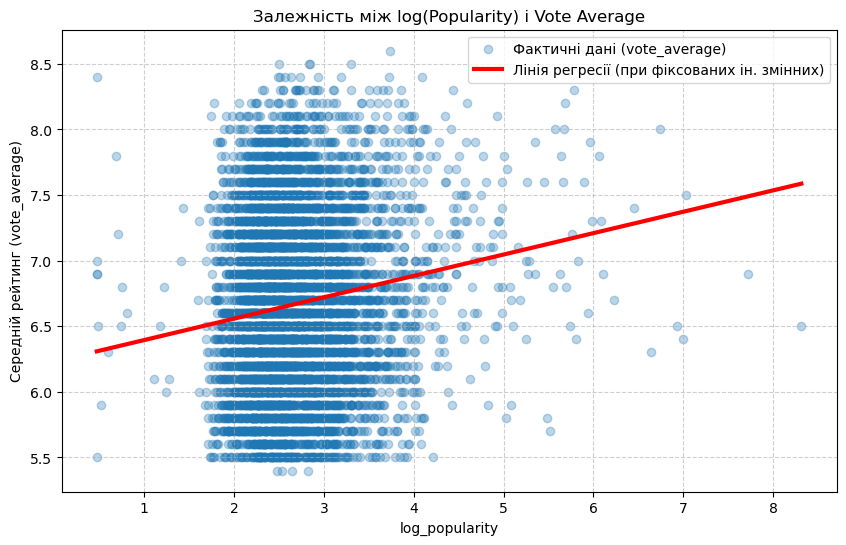

In [2]:
mean_vc = X_train['log_vc'].mean()
mean_year = X_train['year_centered'].mean()

# Створюємо сітку для популярності
p_range = np.linspace(X_train['log_p'].min(), X_train['log_p'].max(), 100)

# Фіксуємо всі змінні, крім log_p
X_line = pd.DataFrame({
    'const': 1.0,
    'log_p': p_range,
    'log_vc': mean_vc,
    'year_centered': mean_year
})

# Фіксуємо dummy-змінну мови, якщо вона була включена
if lang_col and lang_col in X_train.columns:
    X_line[lang_col] = X_train[lang_col].mean()

# Переконайтеся, що порядок стовпців у X_line відповідає порядку параметрів моделі
X_line = X_line.reindex(columns=model.params.index, fill_value=0)

# Прогноз
Y_line_pred = model.predict(X_line)

plt.figure(figsize=(10,6))
plt.scatter(X_train['log_p'], Y_train, alpha=0.3, label='Фактичні дані (vote_average)')
plt.plot(p_range, Y_line_pred, color='red', linewidth=3, 
         label='Лінія регресії (при фіксованих ін. змінних)')

plt.title("Залежність між log(Popularity) і Vote Average")
plt.xlabel("log_popularity")
plt.ylabel("Середній рейтинг (vote_average)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

- порахувати показники: RSS, RMSE, RSE, R^2, t_b. На їх основі оцінити регресію;

In [3]:
Y_pred = model.predict(X_test)

RSS = np.sum((Y_test - Y_pred) ** 2)
RMSE = np.sqrt(RSS / len(Y_test))
RSE = np.sqrt(RSS / (len(Y_test) - len(X.columns) - 1))
R2 = r2_score(Y_test, Y_pred)
t_b = model.tvalues

print(f"RSS = {RSS:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"RSE = {RSE:.4f}")
print(f"R^2 = {R2:.4f}")
print("   t_b: ")
print(t_b)

RSS = 617.7864
RMSE = 0.5931
RSE = 0.5942
R^2 = 0.2175
   t_b: 
const            98.799767
log_vc           11.150044
log_p            12.056896
year_centered   -28.276111
lang_en         -29.684450
dtype: float64


Модель пояснює 21.75% варіативності рейтингу, що є добрим результатом для прогнозування суб'єктивних уподобань. Близькість RMSE до RSE показує, що модель є ефективною. Також можна побачити, що всі змінні мають дуже високі t-значення, що свідчить про їх статистичну значущість.

- використовуючи регресію та оцінки похибки, побудувати передбаченя на 3 кроки вперед.

In [4]:
b0 = 5.8647
b1 = 0.1143
b2 = 0.1628
b3 = -0.0111
b4 = -0.4897

RSE = 0.5942
margin_of_error = 1.96 * RSE 

X_future = pd.DataFrame([
    # Крок 1: Сучасний успішний англомовний фільм
    {'const': 1, 'log_vc': 8.5, 'log_p': 5.0, 'year_centered': 5, 'lang_en': 1},
    
    # Крок 2: Старий, успішний неангломовний фільм
    {'const': 1, 'log_vc': 9.0, 'log_p': 6.0, 'year_centered': -10, 'lang_en': 0},
    
    # Крок 3: Середній англомовний фільм
    {'const': 1, 'log_vc': 7.0, 'log_p': 3.0, 'year_centered': 0, 'lang_en': 1},
])

# Розрахунок прогнозу vote_average за рівнянням
def predict_vote_average(row):
    return (b0 + 
            b1 * row['log_vc'] + 
            b2 * row['log_p'] + 
            b3 * row['year_centered'] + 
            b4 * row['lang_en'])

Y_future_pred = X_future.apply(predict_vote_average, axis=1)

print(f"Використаний RSE: {RSE:.4f}")
print(f"Маржа похибки (95% PI): {margin_of_error:.4f} (1.96 * RSE)")

for i in range(3):
    pred = Y_future_pred.iloc[i]
    lower_bound = pred - margin_of_error
    upper_bound = pred + margin_of_error

    scenario = X_future.iloc[i]
    
    print(f"Крок {i+1}:")
    print(f" - Log(Голосів)={scenario['log_vc']:.1f}, Log(Популярність)={scenario['log_p']:.1f}")
    print(f" - Рік={scenario['year_centered']:.0f}, Англомовний={scenario['lang_en']:.0f}")
    print(f" - Прогноз (Vote Average): {pred:.3f}")
    print(f" - Прогнозний Інтервал (95%): [{lower_bound:.3f} - {upper_bound:.3f}]")

Використаний RSE: 0.5942
Маржа похибки (95% PI): 1.1646 (1.96 * RSE)
Крок 1:
 - Log(Голосів)=8.5, Log(Популярність)=5.0
 - Рік=5, Англомовний=1
 - Прогноз (Vote Average): 7.105
 - Прогнозний Інтервал (95%): [5.940 - 8.270]
Крок 2:
 - Log(Голосів)=9.0, Log(Популярність)=6.0
 - Рік=-10, Англомовний=0
 - Прогноз (Vote Average): 7.981
 - Прогнозний Інтервал (95%): [6.817 - 9.146]
Крок 3:
 - Log(Голосів)=7.0, Log(Популярність)=3.0
 - Рік=0, Англомовний=1
 - Прогноз (Vote Average): 6.663
 - Прогнозний Інтервал (95%): [5.499 - 7.828]


**Висновки.** Промодельована множинна лінійна регресія показала, що хоча всі змінні виявилися статистично значущими, загальна пояснювальна сила моделі є помірною, а отже, близько 80% варіації рейтингу залежить від неврахованих факторів. Також слід зазначити, що частина невизначенності (80%) може залежати від людського фактору, оскільки не кожна модель може точно передбачити, як мільйони людей оцінять художню якість, емоційний вплив або акторську гру. Незважаючи на це, модель є практично корисною для оцінки ризику. Вона має відносно ньзьку середню похибку, а побудова прогнозових інтервалів підтвердила, що ми можемо з 95% впевненістю визначити діапазон майбутнього рейтингу, що є ключовим для прийняття рішень.